# 🔗 GitHub Repository

**Full Code and Tutorial Resources:**

[Gradient Flow Activation Analysis]
(https://github.com/Gouthamnaik189/gradient-flow-activation-analysis)


---

In [8]:
# ============================================
# 1. Imports
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


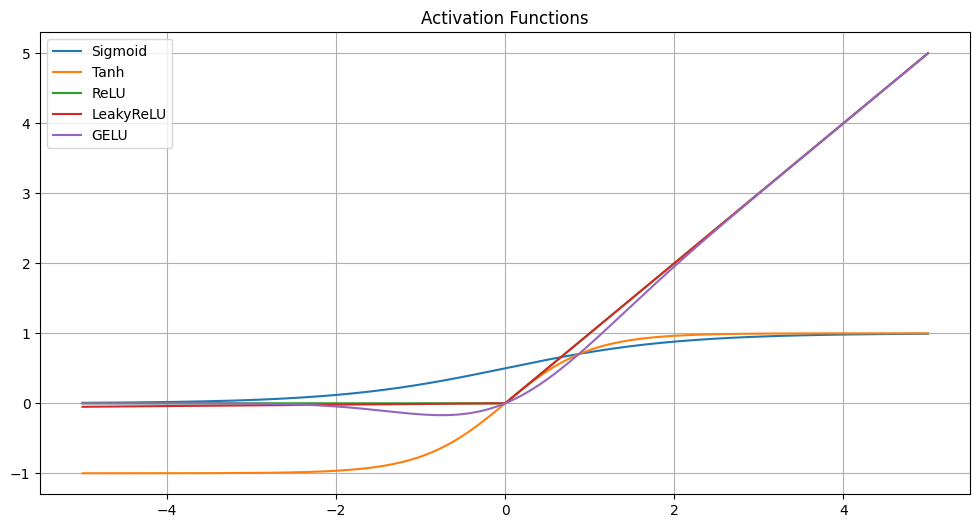

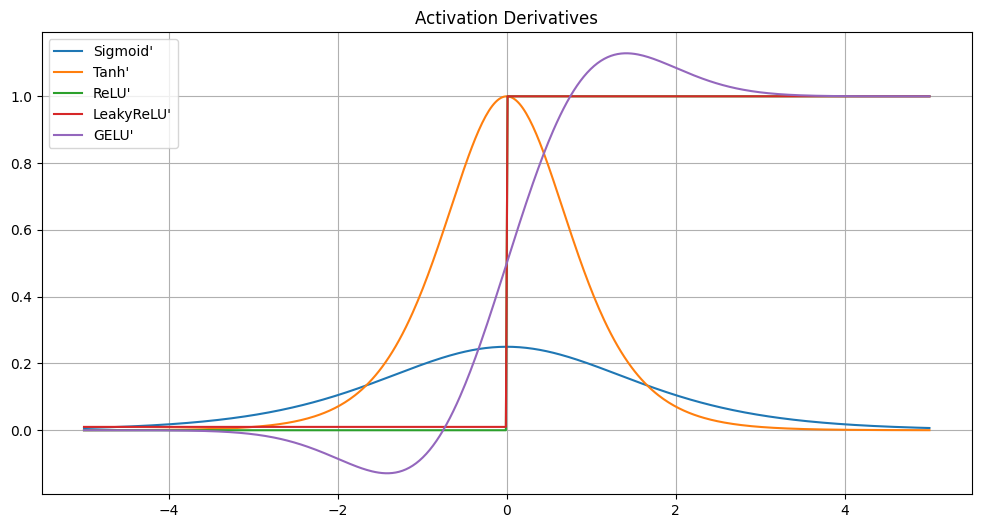

In [9]:
# ============================================
# 2. Plot Activation Functions and Derivatives
# ============================================

# Generate 500 points between -5 and 5.
# This will be used as the input range to visualize activation functions
x = torch.linspace(-5, 5, 500)

# Dictionary of activation functions applied to x.
# Each function is evaluated point-wise so it can be plotted.
activations = {
    "Sigmoid": torch.sigmoid(x),                         # squashes values into (0,1)
    "Tanh": torch.tanh(x),                               # squashes values into (-1,1)
    "ReLU": F.relu(x),                                   # zero for negative, linear for positive
    "LeakyReLU": F.leaky_relu(x, negative_slope=0.01),   # ReLU with small slope for negatives
    "GELU": F.gelu(x)                                    # smooth nonlinear function used in transformers
}

# Compute the derivatives of each activation function.
# These matter because derivative behavior affects gradient flow during training.
derivatives = {
    "Sigmoid'": torch.sigmoid(x) * (1 - torch.sigmoid(x)), # derivative of sigmoid
    "Tanh'": 1 - torch.tanh(x)**2,                         # derivative of tanh
    "ReLU'": (x > 0).float(),                              # 1 if x>0 else 0
    "LeakyReLU'": torch.where(x > 0, torch.ones_like(x), torch.full_like(x, 0.01)), # small slope for negative values
    "GELU'": torch.autograd.functional.jacobian(lambda t: F.gelu(t), x).diag()      # compute jacobian diagonal

}

# Plot activation functions on the same graph.
plt.figure(figsize=(12, 6))
for name, y in activations.items():
    plt.plot(x, y, label=name)
plt.title("Activation Functions")
plt.legend()
plt.grid()
plt.show()

# Plot activation derivatives.
# This helps compare how steepness and saturation differ across functions.
plt.figure(figsize=(12, 6))
for name, y in derivatives.items():
    plt.plot(x, y, label=name)
plt.title("Activation Derivatives")
plt.legend()
plt.grid()
plt.show()


In [10]:
# ============================================
# 3. Deep MLP with Configurable Activation
# ============================================

class DeepNet(nn.Module):
    def __init__(self, activation, depth=20, width=128):
        """
        A fully-connected (MLP) network made intentionally very deep
        so we can observe different behaviors with different activations.

        activation: function to apply after each layer
        depth: number of hidden layers
        width: number of neurons per hidden layer
        """
        super().__init__()
        layers = []
        self.activation = activation                   # store the selected activation

        # Create the hidden layers.
        # All hidden layers have the same width.
        for _ in range(depth):
            layers.append(nn.Linear(width, width))

        # Convert list to ModuleList so PyTorch tracks parameters.
        self.layers = nn.ModuleList(layers)
        self.input_layer = nn.Linear(784, width)       # MNIST images are 28x28 → 784 inputs.
        self.output_layer = nn.Linear(width, 10)       # output logits for 10 classes

    def forward(self, x):

        # Flatten the batch of images into (batch_size, 784)
        x = x.view(x.size(0), -1)

        # First layer + activation
        x = self.activation(self.input_layer(x))

        # Forward through deep stack of hidden layers
        for layer in self.layers:
            x = self.activation(layer(x))

        # Output layer (no activation, because CrossEntropyLoss expects raw logits)
        return self.output_layer(x)


In [11]:
# ============================================
# 4. Load MNIST
# ============================================

# Convert image to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Download and load MNIST dataset
train_data = datasets.MNIST(root=".", train=True, download=True, transform=transform)

# DataLoader batches the data and shuffles it for training.
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


In [12]:
# ============================================
# 5. Training Function + Track Gradient Norms
# ============================================

def train(model, epochs=3):
    """
    Train the model and record the loss curve as well as
    the average gradient norm at each training step.

    Tracking gradient norms helps visualize exploding/vanishing gradients.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    grad_norms = []                          # store gradient magnitude over time
    losses = []                              # store loss values

    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()            # clear old gradients

            output = model(images)           # forward pass
            loss = criterion(output, labels) # Compute classification loss
            loss.backward()                  # Backward pass (compute gradients)

            # Calculate average gradient magnitude across all learnable parameters
            layer_norms = []
            for p in model.parameters():
                if p.grad is not None:
                    layer_norms.append(p.grad.norm().item())
            grad_norms.append(np.mean(layer_norms))

            optimizer.step()                # update weights
            losses.append(loss.item())

    return losses, grad_norms


In [13]:
# ============================================
# 6. Run Experiments for Each Activation
# ============================================


# Define activation functions to compare.
# Same architecture, only activation changes.
activations = {
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "ReLU": F.relu,
    "LeakyReLU": lambda x: F.leaky_relu(x, 0.01),
    "GELU": F.gelu,
}

results = {}

# Train a separate model for each activation and store results.
for name, act in activations.items():
    print(f"Training with {name}...")
    model = DeepNet(activation=act)       # build the network
    losses, grads = train(model)          # train and collect metrics
    results[name] = {"losses": losses, "grads": grads}


Training with Sigmoid...
Training with Tanh...
Training with ReLU...
Training with LeakyReLU...
Training with GELU...


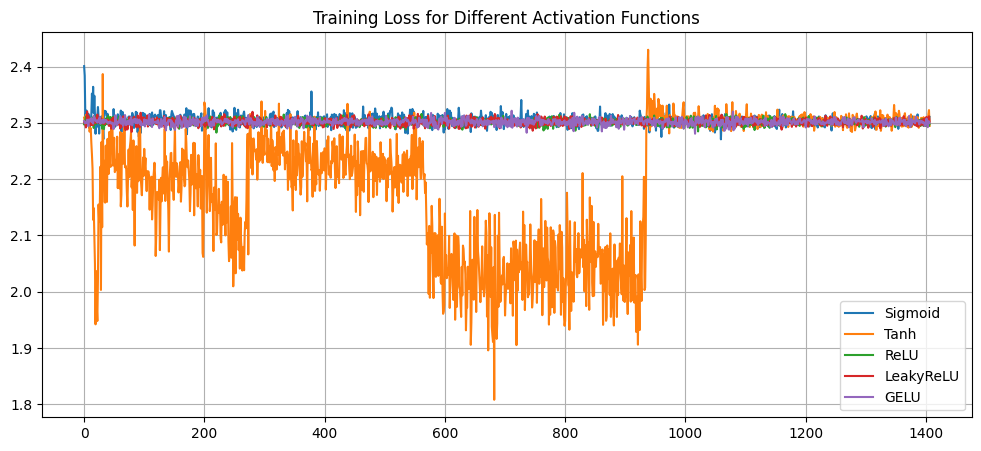

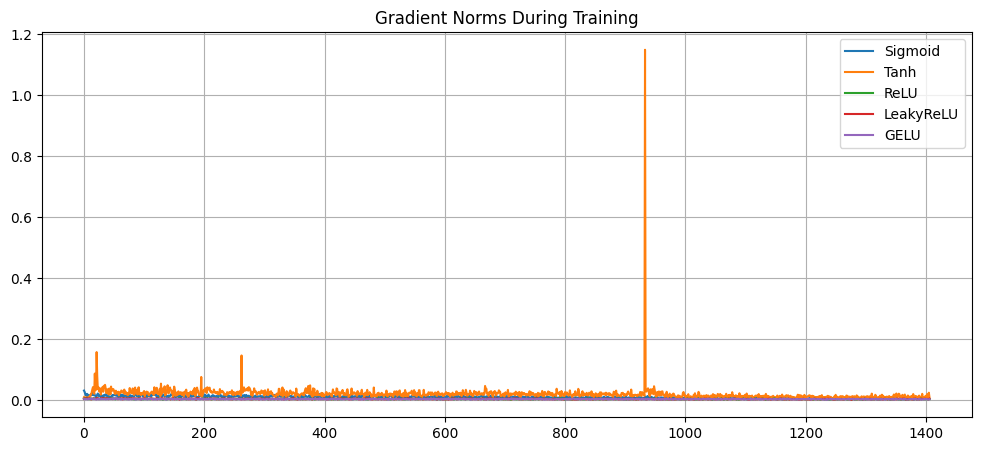

In [14]:
# ============================================
# 7. Plot Training Curves and Gradient Flow
# ============================================

# Plot the loss curves for all activations.
# Helps visualize how activation choice affects optimization speed.

plt.figure(figsize=(12, 5))
for name in results:
    plt.plot(results[name]["losses"], label=name)
plt.title("Training Loss for Different Activation Functions")
plt.legend()
plt.grid()
plt.show()

# Plot gradient norms during training.
# Helps identify exploding/vanishing gradients.

plt.figure(figsize=(12, 5))
for name in results:
    plt.plot(results[name]["grads"], label=name)
plt.title("Gradient Norms During Training")
plt.legend()
plt.grid()
plt.show()
